---

Skeleton points passing it through SAM 

In [207]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import torch

In [208]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print(f"Device selected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Use CPU
    print("Device selected: CPU")

# Output the device being used
print(f"Using device: {device}")


Device selected: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


In [209]:
file_no = 250

In [210]:
rgb_image_path = f"../../Complete_Data/xArm/Final_RGB/{file_no}.png"
mask_image_path = f"../../Complete_Data/xArm/Final_Mask/{file_no}.png"

In [211]:
# rgb_image_path = f"../Calibration - Lab/cleaned_image_rp_3/image_0402.png"
# mask_image_path = f"../Calibration - Lab/seg_mask_images/image_0402.png"

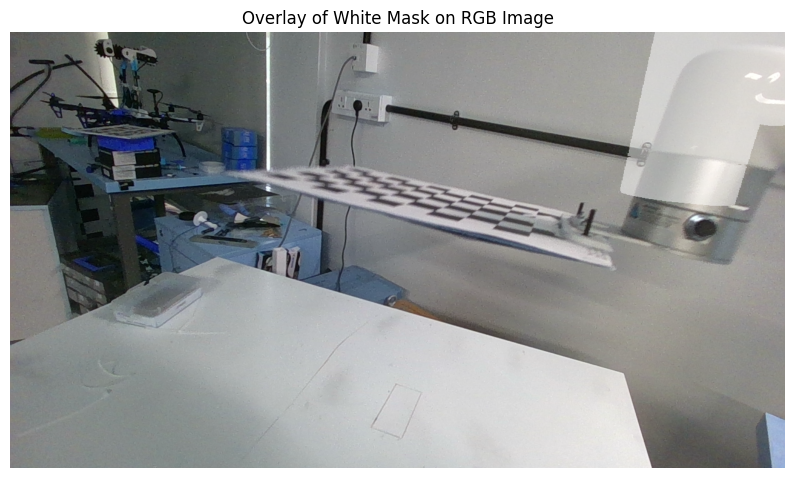

In [212]:
rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  
binary_mask = cv2.inRange(mask_image, 255, 255) 

binary_mask_resized = cv2.resize(binary_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([binary_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image) 

rgb_image_overlay_rgb = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_overlay_rgb)
plt.title("Overlay of White Mask on RGB Image")
plt.axis("off")
plt.show()


(-0.5, 1279.5, 719.5, -0.5)

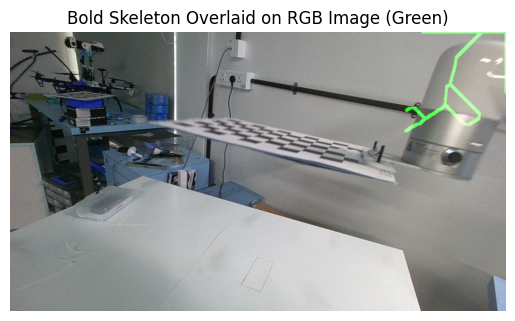

In [213]:

rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

_, binary_mask = cv2.threshold(mask_image, 50, 255, cv2.THRESH_BINARY)

skeleton = cv2.ximgproc.thinning(binary_mask)

bold_skeleton = cv2.dilate(skeleton, np.ones((3, 3), np.uint8), iterations=3)

# Create a green image where the bold skeleton is
green_skeleton = np.zeros_like(rgb_image)
green_skeleton[bold_skeleton == 255] = [0, 255, 0]  # Green color (BGR format)

# Combine the skeleton with the original image
overlay_rgb_skeleton = cv2.addWeighted(rgb_image, 1, green_skeleton, 1, 0)

plt.imshow(cv2.cvtColor(overlay_rgb_skeleton, cv2.COLOR_BGR2RGB))
plt.title("Bold Skeleton Overlaid on RGB Image (Green)")
plt.axis("off")


In [214]:

skeleton_points = np.column_stack(np.where(bold_skeleton > 0))

# print("Skeleton Points:")
# for point in skeleton_points:
#     print(f"x: {point[1]}, y: {point[0]}")


In [215]:
sam_checkpoint = "./segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"  
device = "cpu" # change this when the cuda is set up works  

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)


In [216]:
skeleton_points

array([[   0, 1062],
       [   0, 1063],
       [   0, 1064],
       ...,
       [ 258, 1022],
       [ 258, 1023],
       [ 258, 1024]])

In [217]:
input_points = np.array([[point[1], point[0]] for point in skeleton_points])  # Convert to (x, y) format
input_labels = np.ones(input_points.shape[0])  # Label as foreground points (1 for SAM)


In [218]:
input_points

array([[1062,    0],
       [1063,    0],
       [1064,    0],
       ...,
       [1022,  258],
       [1023,  258],
       [1024,  258]])

In [219]:
torch.cuda.empty_cache()

In [220]:

num_space = 300 # instead of taking all the 12k points , choose spacing  between the points

In [221]:
len(input_points)/num_space

23.75

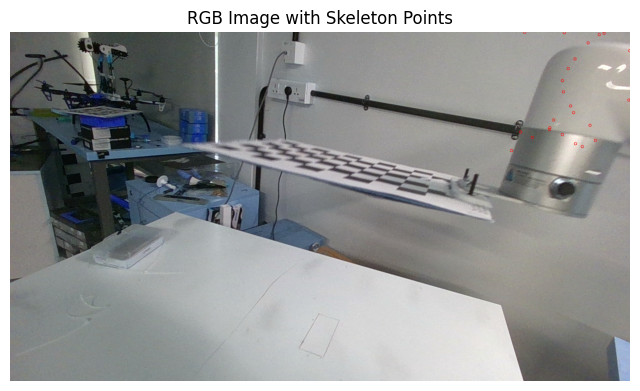

In [222]:
rgb_image = cv2.imread(rgb_image_path)

for point in input_points[::num_space]:
    cv2.circle(rgb_image, (point[0], point[1]), radius=3, color=(0, 0, 255), thickness=1)

rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)

plt.title("RGB Image with Skeleton Points")
plt.axis("off")
plt.show()


In [223]:
predictor.set_image(rgb_image)

masks, _, _ = predictor.predict(
    point_coords=input_points[::num_space],
    point_labels=input_labels[::num_space],
    multimask_output=False,  # Use a single mask for simplicity
)

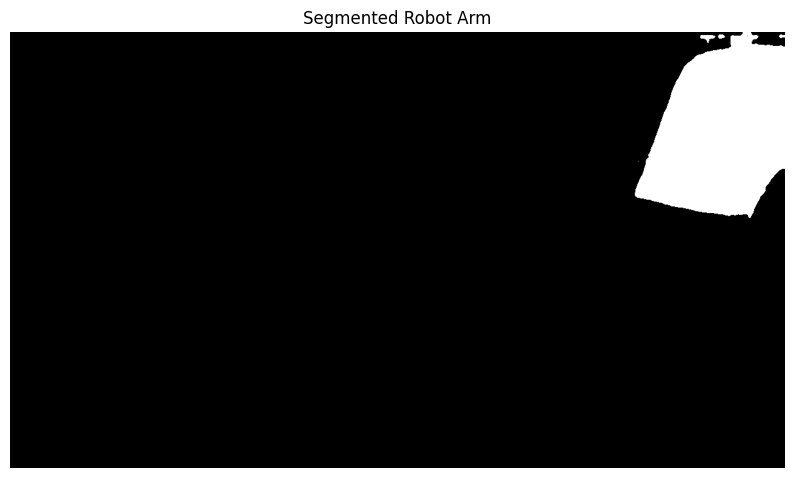

In [224]:
segmented_mask = masks[0] 

plt.figure(figsize=(10, 10))
plt.imshow(segmented_mask, cmap='gray') 
plt.title("Segmented Robot Arm")
plt.axis("off")
plt.show()


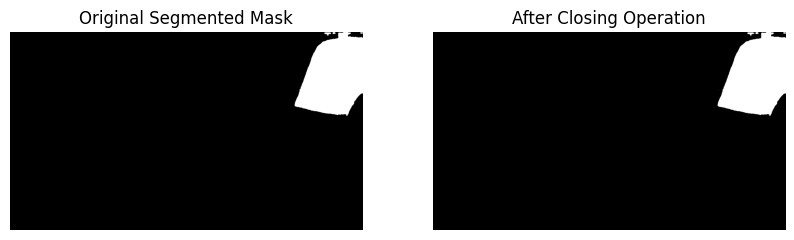

In [225]:
"""
This cell performs closing operation to fill up the holes !!
"""

segmented_mask_uint8 = (segmented_mask * 255).astype(np.uint8) if segmented_mask.max() == 1 else segmented_mask.astype(np.uint8)

kernel = np.ones((5, 5), np.uint8)  # A 5x5 square kernel

closed_mask = cv2.morphologyEx(segmented_mask_uint8, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(segmented_mask_uint8, cmap='gray')
plt.title("Original Segmented Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(closed_mask, cmap='gray')
plt.title("After Closing Operation")
plt.axis("off")

plt.show()


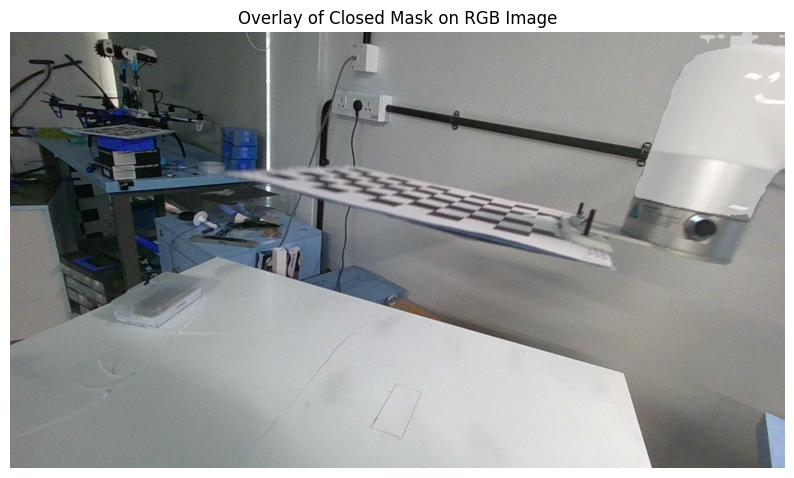

In [226]:


rgb_image = cv2.imread(rgb_image_path)

closed_mask_resized = cv2.resize(closed_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([closed_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image)

rgb_image_overlay_rgb_sam = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image_overlay_rgb_sam)
plt.title("Overlay of Closed Mask on RGB Image")
plt.axis("off")
plt.show()



In [227]:

rgb_image = cv2.imread(rgb_image_path)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  
binary_mask = cv2.inRange(mask_image, 255, 255) 

binary_mask_resized = cv2.resize(binary_mask, (rgb_image.shape[1], rgb_image.shape[0]))

mask_rgb = np.stack([binary_mask_resized] * 3, axis=-1)

alpha = 0.5

rgb_image_overlay = np.where(mask_rgb == 255,
                             rgb_image * (1 - alpha) + mask_rgb * alpha,  
                             rgb_image) 

rgb_image_overlay_rgb = cv2.cvtColor(rgb_image_overlay.astype(np.uint8), cv2.COLOR_BGR2RGB)



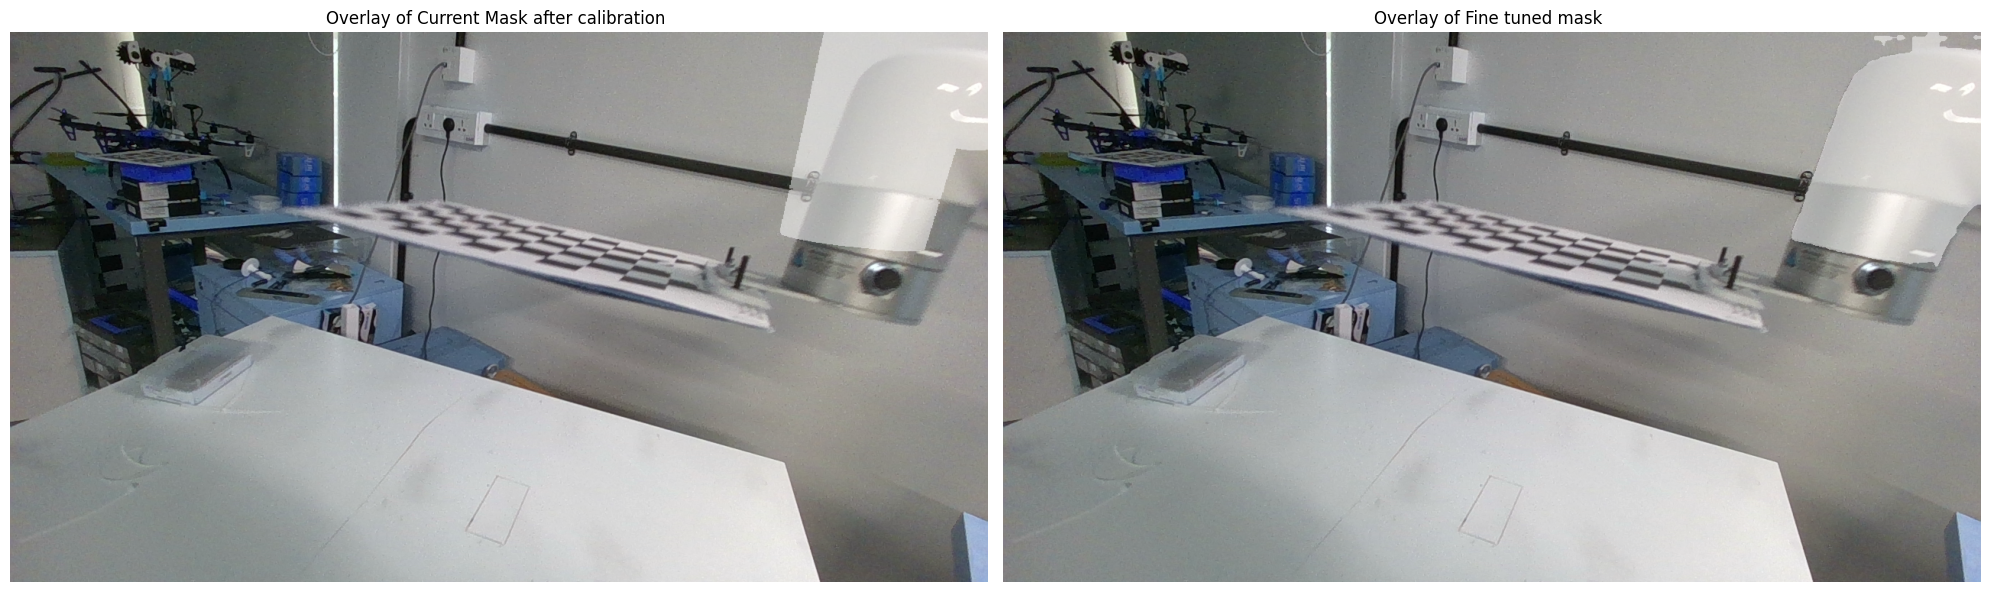

In [228]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(rgb_image_overlay_rgb)
plt.title("Overlay of Current Mask after calibration ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_image_overlay_rgb_sam)
plt.title("Overlay of Fine tuned mask ")
plt.axis("off")

plt.tight_layout()
plt.show()